In [372]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [373]:
loans = pd.DataFrame()

dirname = os.path.abspath('')
path = os.path.join(dirname, 'data')
all_files = glob.glob(os.path.join(path , "*.gz"))
for filename in all_files:
    df = pd.read_csv(filename, compression='gzip')
    quarterName = os.path.basename(filename).split('.', 1)[0]
    year = quarterName[0:4]
    quarter = quarterName[5:]
    df['year'] = year
    df['quarter'] = quarter
    loans = pd.concat([loans,df])

loans = loans.set_index('id')

In [374]:
print('Number of loans = {}'.format(loans.shape[0]))
print('Shape: {}'.format(loans.shape))
print('Columns: {}'.format(list(loans.columns)))

Number of loans = 438991
Shape: (438991, 56)
Columns: ['funded_amnt', 'term', 'int_rate', 'installment', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'application_type', 'annual_inc_joint', 'dti_joint', 'open_act_il', 'open_il_24m', 'il_util', 'open_rv_24m', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'total_bc_limit', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths

In [375]:
print(loans.info())
loans.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438991 entries, 73688651 to 124836913
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     438991 non-null  int64  
 1   term                            438991 non-null  object 
 2   int_rate                        438991 non-null  object 
 3   installment                     438991 non-null  float64
 4   emp_title                       408624 non-null  object 
 5   emp_length                      408978 non-null  object 
 6   home_ownership                  438991 non-null  object 
 7   annual_inc                      438991 non-null  float64
 8   loan_status                     438991 non-null  object 
 9   purpose                         438991 non-null  object 
 10  zip_code                        438991 non-null  object 
 11  addr_state                      438991 non-null  object 
 12  dti   

,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,...,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,year,quarter
id,,,,,,,,,,,,,,,,,,,,,
124986994,5000,36 months,10.42%,162.33,Team Lead,2 years,MORTGAGE,65000.0,Current,debt_consolidation,...,80.0,0,60814,20800,NaN,NaN,NaN,NaN,2017,4
112711790,18000,60 months,9.93%,381.83,Director,10+ years,MORTGAGE,185000.0,Current,credit_card,...,0.0,0,38322,18500,NaN,NaN,NaN,NaN,2017,3
91121033,25450,36 months,17.99%,919.96,manager,1 year,MORTGAGE,70000.0,Fully Paid,credit_card,...,75.0,0,51427,12800,NaN,NaN,NaN,NaN,2016,4
93428232,29400,36 months,24.74%,1164.90,Environmental Scientist,9 years,RENT,44000.0,Current,debt_consolidation,...,100.0,1,44915,9800,NaN,NaN,NaN,NaN,2016,4
117226333,1800,36 months,15.05%,62.45,Asst. Commissioner,3 years,MORTGAGE,44000.0,Current,home_improvement,...,50.0,0,7178,6500,NaN,NaN,NaN,NaN,2017,3


In [376]:
loans['term'] = loans['term'].str.extract('(\d+)')
loans['int_rate'] = loans['int_rate'].str.rstrip('%')
loans['emp_length'] = loans['emp_length'].str.replace('< 1 year', '0')
loans['emp_length'] = loans['emp_length'].str.replace('10+ years', '10')
loans['emp_length'] = loans['emp_length'].str.extract('(\d+)')
loans['zip_code'] = loans['zip_code'].str.rstrip('xx')
loans.head()

C:\Users\steph\AppData\Local\Temp\ipykernel_15140\3317664037.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  loans['emp_length'] = loans['emp_length'].str.replace('10+ years', '10')


,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,...,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,year,quarter
id,,,,,,,,,,,,,,,,,,,,,
73688651,4000,36,11.99,132.84,Fraud analyst,8,RENT,45000.0,Fully Paid,debt_consolidation,...,0.0,0,1102,7500,NaN,NaN,NaN,NaN,2016,1
75678977,7200,36,11.47,237.33,Client Relations Manager,0,RENT,85000.0,Current,debt_consolidation,...,100.0,0,33021,14000,NaN,NaN,NaN,NaN,2016,1
71905793,20000,36,16.29,706.01,Registerd nurse,8,MORTGAGE,56000.0,Current,debt_consolidation,...,75.0,2,54298,9700,NaN,NaN,NaN,NaN,2016,1
74231221,16000,60,12.99,363.97,Financial Advisor,5,MORTGAGE,110000.0,Current,debt_consolidation,...,87.5,0,45733,39400,NaN,NaN,NaN,NaN,2016,1
68884968,28000,60,15.31,670.69,Pharmacist-in-Charge,3,MORTGAGE,180000.0,Current,debt_consolidation,...,100.0,0,273107,51800,NaN,NaN,NaN,NaN,2016,1


In [377]:
loans['loan_status'].value_counts()

Current               251552
Fully Paid            132055
Charged Off            40902
Late (31-120 days)      8209
In Grace Period         4016
Late (16-30 days)       2257
Name: loan_status, dtype: int64

In [378]:
good = ['Fully Paid']
bad = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)']
inprogress = ['Current', 'In Grace Period']
finishedloans = loans[(loans['loan_status'] != inprogress[0]) & (loans['loan_status'] != inprogress[1])]
loans['loan_finished'] = 1
for status in loans['loan_status'].unique():
    if status in inprogress:
        loans.loc[loans['loan_status'] == status, 'loan_finished'] = 0
    if status in good:
        loans.loc[loans['loan_status'] == status, 'good_loan'] = 1
    if status in bad:
        loans.loc[loans['loan_status'] == status, 'good_loan'] = 0
loans['loan_finished'].fillna(1, inplace=True)

print(loans['loan_finished'].value_counts())
loans['good_loan'].value_counts()

0    255568
1    183423
Name: loan_finished, dtype: int64


1.0    132055
0.0     51368
Name: good_loan, dtype: int64

In [379]:
loans.dtypes

funded_amnt                         int64
term                               object
int_rate                           object
installment                       float64
emp_title                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
loan_status                        object
purpose                            object
zip_code                           object
addr_state                         object
dti                               float64
delinq_2yrs                         int64
earliest_cr_line                   object
fico_range_high                     int64
inq_last_6mths                    float64
mths_since_last_delinq            float64
open_acc                            int64
revol_bal                           int64
revol_util                         object
total_acc                           int64
application_type                   object
annual_inc_joint                  

In [380]:
loans['term'] = pd.to_numeric(loans['term'])
loans['int_rate'] = pd.to_numeric(loans['int_rate'])
loans['emp_length'] = pd.to_numeric(loans['emp_length'])
loans['zip_code'] = pd.to_numeric(loans['zip_code'])
loans['year'] = pd.to_numeric(loans['year'])
loans['quarter'] = pd.to_numeric(loans['quarter'])
loans.dtypes

funded_amnt                         int64
term                                int64
int_rate                          float64
installment                       float64
emp_title                          object
emp_length                        float64
home_ownership                     object
annual_inc                        float64
loan_status                        object
purpose                            object
zip_code                            int64
addr_state                         object
dti                               float64
delinq_2yrs                         int64
earliest_cr_line                   object
fico_range_high                     int64
inq_last_6mths                    float64
mths_since_last_delinq            float64
open_acc                            int64
revol_bal                           int64
revol_util                         object
total_acc                           int64
application_type                   object
annual_inc_joint                  

In [381]:
loans.describe()

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,zip_code,dti,delinq_2yrs,fico_range_high,...,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_inq_last_6mths,year,quarter,loan_finished,good_loan
count,438991.000000,438991.000000,438991.000000,438991.000000,408978.000000,4.389910e+05,438991.000000,438706.000000,438991.000000,438991.000000,...,438991.000000,4.389910e+05,438991.000000,19670.000000,19671.000000,19671.000000,438991.000000,438991.000000,438991.000000,183423.000000
mean,14790.996000,42.383092,13.144058,443.451421,5.932957,7.978605e+04,507.177582,19.053124,0.343415,701.844279,...,0.139611,5.235281e+04,23299.998446,31507.813523,669.674902,0.675258,2016.505222,2.496074,0.417829,0.719948
std,9323.740928,10.604273,5.062600,277.262393,3.757146,8.194272e+04,309.201018,14.427149,0.930063,32.929589,...,0.384764,5.106754e+04,23030.807798,25024.701622,44.342382,1.033539,0.499973,1.132067,0.493202,0.449026
min,1000.000000,36.000000,5.320000,6.680000,0.000000,0.000000e+00,7.000000,-1.000000,0.000000,664.000000,...,0.000000,0.000000e+00,0.000000,0.000000,544.000000,0.000000,2016.000000,1.000000,0.000000,0.000000
25%,7500.000000,36.000000,9.490000,241.130000,2.000000,4.759490e+04,230.000000,12.130000,0.000000,674.000000,...,0.000000,2.138700e+04,8400.000000,14413.000000,644.000000,0.000000,2016.000000,1.000000,0.000000,0.000000
50%,12000.000000,36.000000,12.620000,370.910000,6.000000,6.626400e+04,468.000000,18.100000,0.000000,694.000000,...,0.000000,3.874100e+04,16400.000000,25186.000000,669.000000,0.000000,2017.000000,3.000000,0.000000,1.000000
75%,20000.000000,60.000000,15.590000,593.490000,10.000000,9.500000e+04,797.000000,24.800000,0.000000,719.000000,...,0.000000,6.611400e+04,30400.000000,41353.750000,694.000000,1.000000,2017.000000,4.000000,1.000000,1.000000
max,40000.000000,60.000000,30.990000,1719.830000,10.000000,1.099920e+07,999.000000,999.000000,42.000000,850.000000,...,8.000000,3.408095e+06,719500.000000,304206.000000,850.000000,6.000000,2017.000000,4.000000,1.000000,1.000000


In [382]:
loans.nunique()

funded_amnt                         1554
term                                   2
int_rate                             169
installment                        44023
emp_title                         120032
emp_length                            11
home_ownership                         5
annual_inc                         28079
loan_status                            6
purpose                               14
zip_code                             908
addr_state                            50
dti                                 6986
delinq_2yrs                           29
earliest_cr_line                     680
fico_range_high                       38
inq_last_6mths                         6
mths_since_last_delinq               147
open_acc                              74
revol_bal                          61561
revol_util                          1163
total_acc                            126
application_type                       2
annual_inc_joint                    5103
dti_joint       

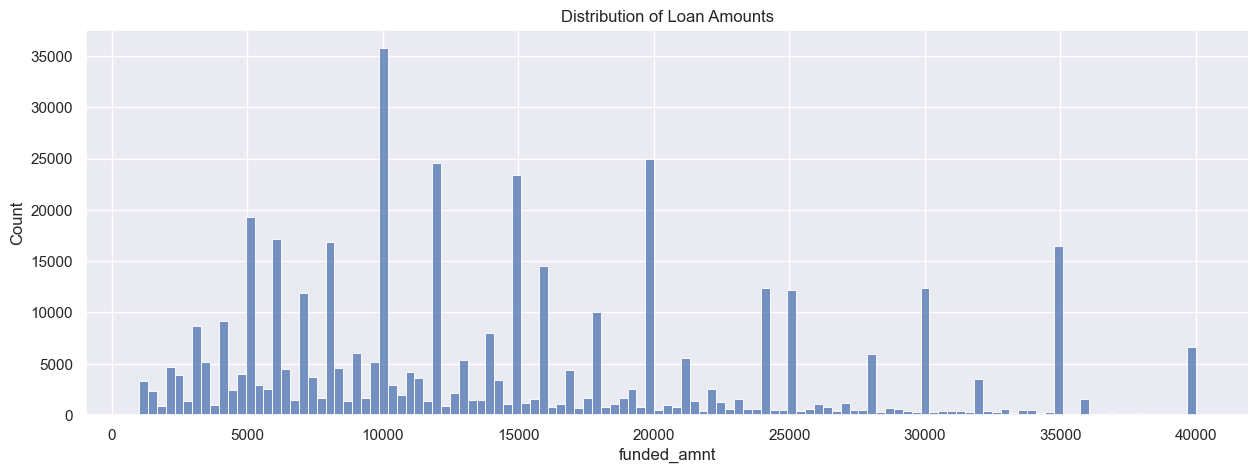

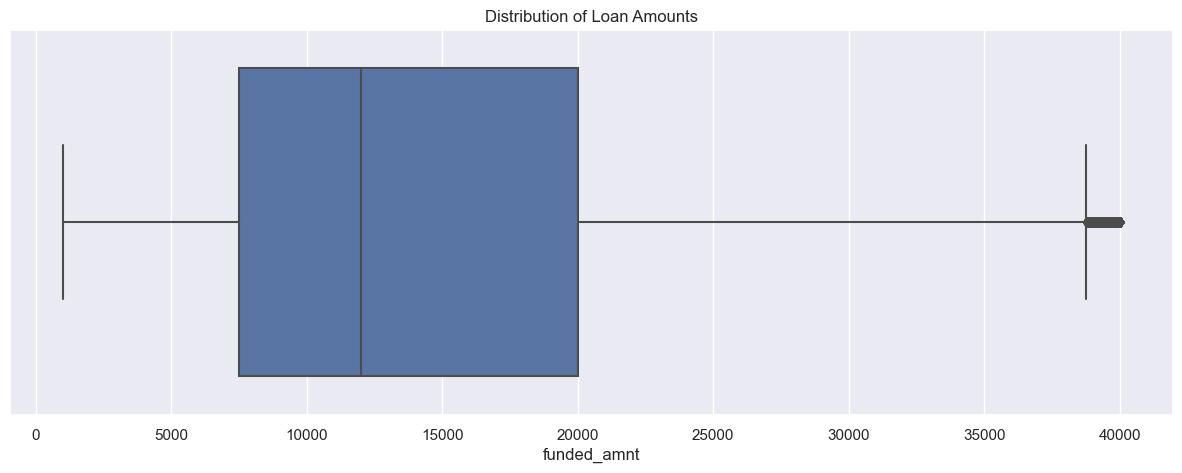

In [383]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Loan Amounts')
sns.histplot(x='funded_amnt', data=loans)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Distribution of Loan Amounts')
sns.boxplot(x='funded_amnt', data=loans)
plt.show()

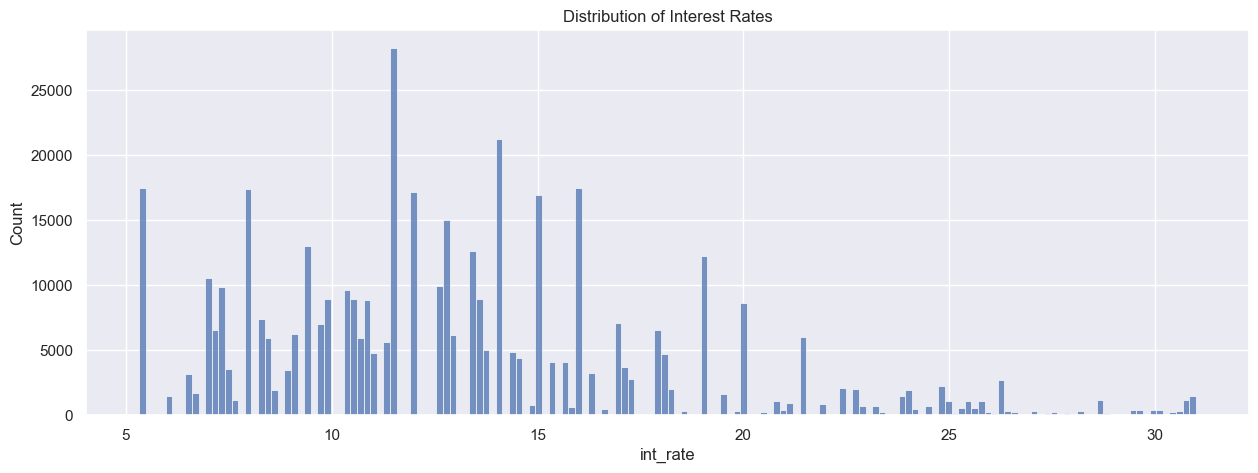

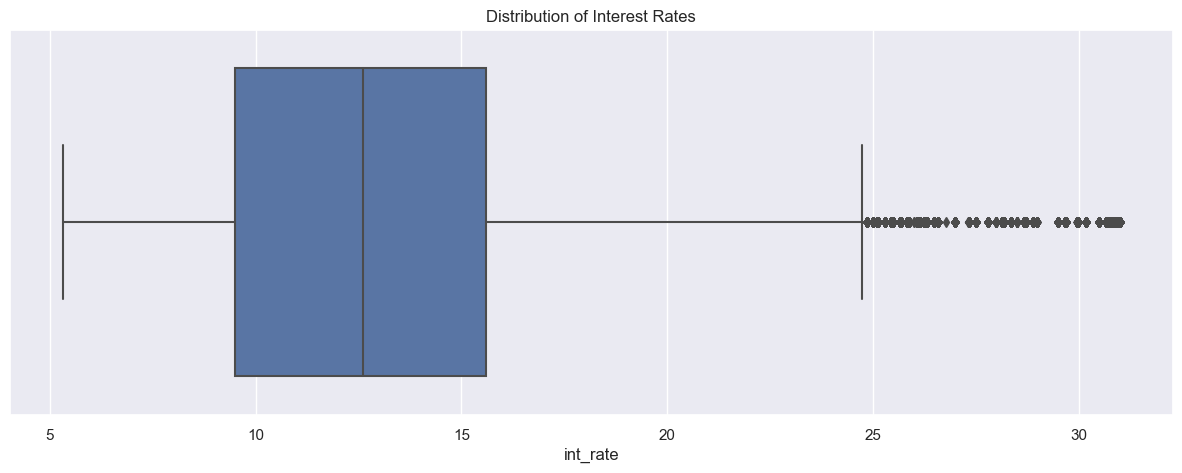

In [384]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Interest Rates')
sns.histplot(x='int_rate', data=loans)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Distribution of Interest Rates')
sns.boxplot(x='int_rate', data=loans)
plt.show()

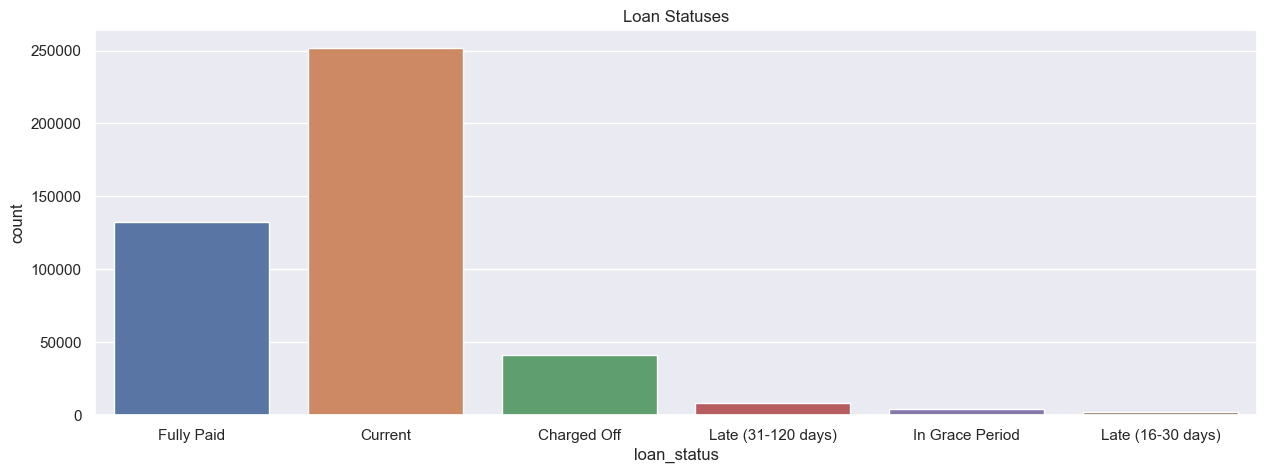

In [385]:
plt.figure(figsize=(15,5))
plt.title('Loan Statuses')
sns.countplot(data=loans,x="loan_status")
plt.show()

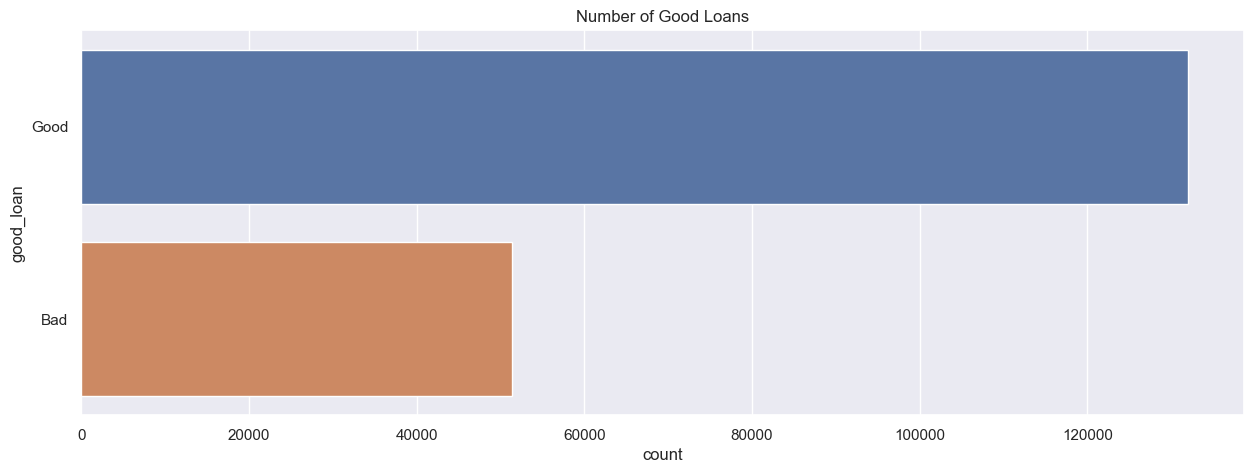

In [392]:
goodloans = loans['good_loan']
goodloans.replace(0.0, 'Bad', inplace=True)
goodloans.replace(1.0, 'Good', inplace=True)

plt.figure(figsize=(15,5))
plt.title('Number of Good Loans')
sns.countplot(y=goodloans)
plt.show()

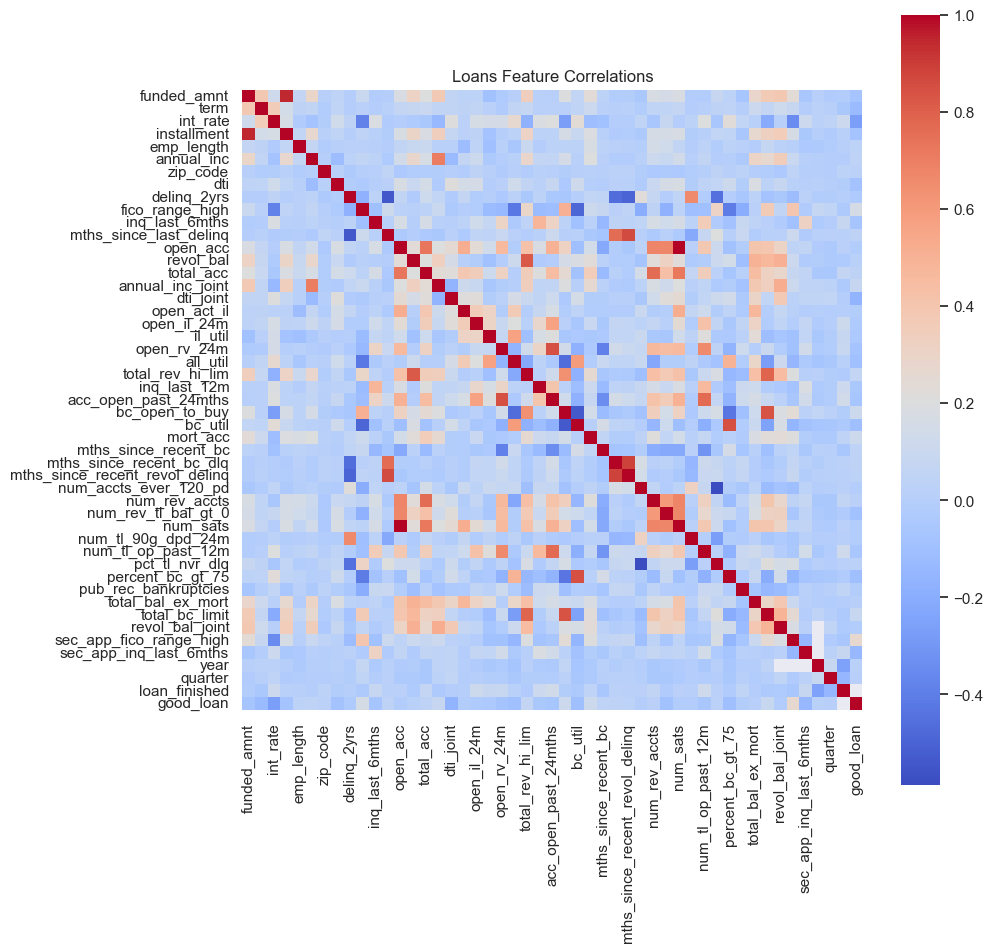

In [388]:
fig, axs = plt.subplots(nrows=1, figsize=(10, 10))
c = loans.corr()
sns.heatmap(loans.corr(),  annot=False, square=True, cmap='coolwarm')
plt.title('Loans Feature Correlations')
plt.show()